In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Ewert|Roboto&effect=3d|ice|');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: #818286; font-family: 'Roboto';}
span {font-family:'Roboto'; color:black; text-shadow: 5px 5px 5px #aaa;}  
div.output_area pre{font-family:'Roboto'; font-size:110%; color:purple;}      
</style>

<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

### Aprendizaje NO supervisado - 2019 
#### Práctico: Reglas de Asociación

#### Tarea: 

* Obtener reglas de asociación entre películas en el dataset movilents
* Aplicar diferentes métricas de ordenamiento


En estre práctico se va a trabajar sobre el dataset MovieLens 20M Dataset (https://grouplens.org/datasets/movielens/20m/) que describe ratings y free-text tagging activities de MovieLens,que es un servicio de recomendación de películas. 


In [1]:
from timeit import default_timer
start = default_timer()

import pandas as pd
import numpy as np 
import os
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

In [2]:
print(os.listdir("ml-20m"))

['links.csv', 'movies.csv', 'ratings.csv', 'tags.csv', 'genome-scores.csv', 'genome-tags.csv', 'README.txt']


Contenido:
    
No se incluye información demográfica. Cada usuario está representado solo por un id.
Los datos se distribuyen en seis archivos: 

* **tags.csv**, contiene las etiquetas aplicadas de las películas, por los usuarios: 

    * userId
    * movieId
    * tag
    * timestamp

* **ratings.csv**, contiene los ratings de las películas por los usuarios: 

    * userId
    * movieId
    * rating
    * timestamp
    
* **movies.csv**, contiene la información de la película:
    * movieId
    * title
    * genres

* **links.csv** contiene identificadores que pueden ser usados para acceder a otras fuentes: 
    * movieId 
    * imdbId
    * tmbdId

* **genome-scores.csv** contiene etiquetas de relevancia para la película:
    * movieId
    * tagId
    * relevance

* **genome-tags.csv** contiene la descripción de las etiquetas:
    * tagId 
    * tag

Vamos a analizar especialmente los archivos: *ratings.csv* y *movies.csv*, ya que queremos encontrar reglas de asociación entre películas y los usuarios (como sistema de recomendación)

In [3]:
#import movies data set and look at columns
movies = pd.read_csv("ml-20m/movies.csv")
movies.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [10]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
movies.count()

movieId    27278
title      27278
genres     27278
dtype: int64

In [6]:
# what we need is that movie id and title
#movies = movies.loc[:,["movieId","title"]]
#movies.head(5)

In [4]:
#import ratings data set and look at columns
ratings = pd.read_csv("ml-20m/ratings.csv")
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [6]:
ratings.count()

userId       20000263
movieId      20000263
rating       20000263
timestamp    20000263
dtype: int64

In [7]:
# what we need is that user id, movie id and rating
ratings = ratings.loc[:,["userId","movieId","rating"]]
ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [8]:
ratings["rating"].describe()

count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [52]:
# then merge movie and rating data
data = pd.merge(movies,ratings)


In [11]:
# now lets look at our data 
data.tail()

,movieId,title,genres,userId,rating
20000258,131254,Kein Bund für's Leben (2007),Comedy,79570,4.0
20000259,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,79570,4.0
20000260,131258,The Pirates (2014),Adventure,28906,2.5
20000261,131260,Rentun Ruusu (2001),(no genres listed),65409,3.0
20000262,131262,Innocence (2014),Adventure|Fantasy|Horror,133047,4.0


#### Data Cleaning: Handling Missing Data

In [53]:
data.shape

(20000263, 6)

In [14]:
data.isnull().any().any()

False

No hay datos nulos!

#### Visualización y análisis exploratorio de datos:

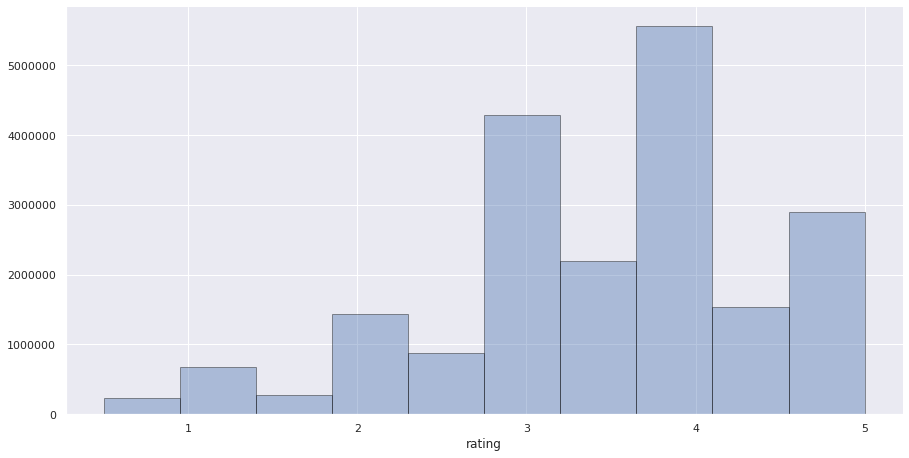

In [43]:
plt.figure(figsize=(15,7.5))
sns.set(style="darkgrid")
sns.distplot(data['rating'].dropna(), bins=10, kde=False, hist_kws={'edgecolor':'black'})
sns.despine()

In [62]:
avg_ratings= data.groupby('movieId', as_index=False).mean()
del avg_ratings['userId']
avg_ratings.head()

,movieId,rating
0,1,3.921240
1,2,3.211977
2,3,3.151040
3,4,2.861393
4,5,3.064592


In [65]:
mov_avg_rtg = movies.merge(avg_ratings, on='movieId', how='inner')
mov_avg_rtg.head()

,movieId,title,genres,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.921240
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.211977
2,3,Grumpier Old Men (1995),Comedy|Romance,3.151040
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.861393
4,5,Father of the Bride Part II (1995),Comedy,3.064592


In [ ]:
#Extract year from title
#movies['year'] = movies['title'].str.extract('.*\((.*)\).*', expand=True)

In [60]:
# all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']

movieId
1                                        Toy Story (1995)
32              Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
47                            Seven (a.k.a. Se7en) (1995)
50                             Usual Suspects, The (1995)
110                                     Braveheart (1995)
150                                      Apollo 13 (1995)
260             Star Wars: Episode IV - A New Hope (1977)
296                                   Pulp Fiction (1994)
318                      Shawshank Redemption, The (1994)
356                                   Forrest Gump (1994)
377                                          Speed (1994)
380                                      True Lies (1994)
457                                  Fugitive, The (1993)
480                                  Jurassic Park (1993)
527                               Schindler's List (1993)
588                                        Aladdin (1992)
589                     Terminator 2: Judgment Day (1991)
590   

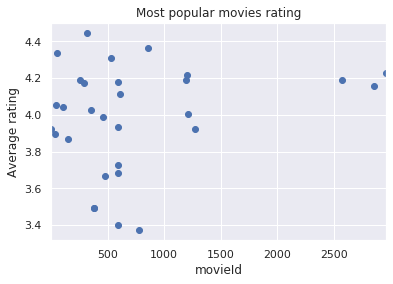

In [61]:
# Let's check those movies with +40k reviews, those should be pretty popular movies!
print(movies.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]]['title'])
# Let's check the average rating too, those should be pretty good movies!
ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]].groupby('movieId').mean().rating.plot(style='o')
plt.ylabel('Average rating')
plt.title('Most popular movies rating')
plt.show()

In [66]:
# Which is the best most popular movie ever??
tmp = ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]].groupby('movieId').mean()
best = movies.set_index('movieId').loc[tmp.rating.idxmax].title
print ('Best most popular movie ever is...%s' %best)

### https://www.kaggle.com/cesarcf1977/movielens-data-analysis-beginner-s-first

Best most popular movie ever is...Shawshank Redemption, The (1994)


### Reglas de asociación

In [67]:
# then merge movie and rating data
data = pd.merge(movies,ratings)
data.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,944919407
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,858275452
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,833981871
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,943497887
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,1230858821


In [91]:
data.shape

(100000, 6)

In [97]:
userId_ord=data.sort_values( by='userId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
userId_ord


,movieId,title,genres,userId,rating,timestamp
49695,2,Jumanji (1995),Adventure|Children|Fantasy,1,3.5,1112486027
71938,3,Grumpier Old Men (1995),Comedy|Romance,2,4.0,974820889
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,944919407
99590,6,Heat (1995),Action|Crime|Thriller,4,3.0,840879227
49696,2,Jumanji (1995),Adventure|Children|Fantasy,5,3.0,851527569
71939,3,Grumpier Old Men (1995),Comedy|Romance,6,3.0,858275558
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,858275452
71940,3,Grumpier Old Men (1995),Comedy|Romance,7,3.0,1011208463
99591,6,Heat (1995),Action|Crime|Thriller,8,3.0,833982631
71941,3,Grumpier Old Men (1995),Comedy|Romance,8,5.0,833981733


In [69]:
data = data.iloc[:100000,:];

In [70]:
data.shape

(100000, 6)

In [98]:
srtdr=userId_ord.values[:,[3,1]]
print(srtdr)

[[1 'Jumanji (1995)']
 [2 'Grumpier Old Men (1995)']
 [3 'Toy Story (1995)']
 ...
 [138491 'Toy Story (1995)']
 [138493 'Jumanji (1995)']
 [138493 'Toy Story (1995)']]


In [99]:
transactions=[]
for title, userId  in groupby(srtdr, lambda x: x[0]):
    transactions.append([item[1] for item in  userId])
print(transactions)

#mvs_userId=data.sort_values(by='userId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#print(mvs_userId)
#srtdr=data.groupby('userId').apply(lambda x: x.sort_values(["title"], ascending = True,inplace=False, kind='quicksort', na_position='last'))
#srtdr;
#srtdr.columns=['usr_title']

#display(compras_df.head())
#mcompras_df=compras_df.sort_values( by='order_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#compras=compras_df.values[:,[0,2]]
#print(compras)

[['Jumanji (1995)'], ['Grumpier Old Men (1995)'], ['Toy Story (1995)'], ['Heat (1995)'], ['Jumanji (1995)'], ['Grumpier Old Men (1995)', 'Toy Story (1995)'], ['Grumpier Old Men (1995)'], ['Heat (1995)', 'Grumpier Old Men (1995)', 'Toy Story (1995)'], ['Toy Story (1995)'], ['Toy Story (1995)'], ['Father of the Bride Part II (1995)', 'Toy Story (1995)', 'Heat (1995)', 'Grumpier Old Men (1995)'], ['Toy Story (1995)', 'Jumanji (1995)'], ['Toy Story (1995)'], ['Heat (1995)', 'Toy Story (1995)'], ['Heat (1995)'], ['Toy Story (1995)', 'Heat (1995)', 'Grumpier Old Men (1995)'], ['Heat (1995)'], ['Toy Story (1995)', 'Heat (1995)'], ['Toy Story (1995)'], ['Heat (1995)', 'Father of the Bride Part II (1995)', 'Toy Story (1995)'], ['Jumanji (1995)'], ['Father of the Bride Part II (1995)'], ['Toy Story (1995)'], ['Heat (1995)'], ['Toy Story (1995)', 'Jumanji (1995)'], ['Grumpier Old Men (1995)'], ['Heat (1995)', 'Toy Story (1995)'], ['Waiting to Exhale (1995)'], ['Father of the Bride Part II (1995)'

In [34]:
srtdr=data[['userId', 'title']].groupby('userId').apply(lambda x: x.sort_values(["userId"], ascending = True,inplace=False, kind='quicksort', na_position='last'))
srtdr

,,userId,title
userId,,,
3,0,3,Toy Story (1995)
6,1,6,Toy Story (1995)
8,2,8,Toy Story (1995)
10,3,10,Toy Story (1995)
11,4,11,Toy Story (1995)
12,5,12,Toy Story (1995)
13,6,13,Toy Story (1995)
14,7,14,Toy Story (1995)
16,8,16,Toy Story (1995)


In [41]:
##mvs_userId=data.sort_values(by='userId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')[:10]



[[3 'Toy Story (1995)']
 [6 'Toy Story (1995)']
 [8 'Toy Story (1995)']
 ...
 [2700 'Toy Story (1995)']
 [2702 'Toy Story (1995)']
 [2704 'Toy Story (1995)']]


In [28]:
srtdr

,,userId,title
userId,,,
3,0,3,Toy Story (1995)
6,1,6,Toy Story (1995)
8,2,8,Toy Story (1995)
10,3,10,Toy Story (1995)
11,4,11,Toy Story (1995)
12,5,12,Toy Story (1995)
13,6,13,Toy Story (1995)
14,7,14,Toy Story (1995)
16,8,16,Toy Story (1995)


In [ ]:
srtdr.apply(lambda _df: _df.sort_values(by=['id'])
            
            f.groupby(["name"]).apply(lambda x: x.sort_values(["count_1"], ascendi

In [74]:
#sorting data frame by userId 
mcompras_df=srtdr.sort_values(by='userId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

AttributeError: Cannot access callable attribute 'sort_values' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [75]:
data.sort_values(['userId', 'title'])



KeyboardInterrupt: 

In [ ]:
#decodificar el nombre de los productos
compras_df = pd.merge(orders[['order_id','product_id']], items_names[['product_id','product_name']] ,on='product_id', how= "inner")

display(compras_df.head())
mcompras_df=compras_df.sort_values( by='order_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
compras=compras_df.values[:,[0,2]]
print(compras)

In [ ]:
## new data frame with split movieTitle and movieYear 
#data["movieTitle"]= data["title"].str.split("\s+\(").str[0]
#data["movieYear"]= data["title"].str.split("\s+\(").str[1]
#data["movieYear"]= data["movieYear"].str.split("\)").str[0]
#data=data.drop(["title"], axis=1)


In [177]:
#data_columns = 'movieYear'

In [181]:
#movies = (movies.drop(data_columns, axis=1).join(movies[data_columns].apply(pd.to_numeric, errors='coerce', downcast='unsigned')))

In [45]:
##Discard movies that have no release year/invalid title format: 
#movies=movies.dropna()
#movies